In [1]:
if (!require("DT")) install.packages('DT')
library(DT)

library(ggplot2)
library(ggpubr)
library(ggthemes)
library(tidyverse)

library(car) 
library(dplyr)
library(reshape)

library(limma)
library(tibble)
library(EnhancedVolcano)

if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("impute")

In [2]:
# Data Input
metabolomics_data <- read.csv('metabolomics_data.csv', check.names = F, row.names = 1)
metabolomics_meta <- read.csv('metabolomics_annotation.csv')
samples_raw <- read.csv('sample_annotation.csv', na.strings=c("NA","NaN", ""))

In [3]:
# Clean data
int.mat <- metabolomics_data
rowNms <- rownames(int.mat)
colNms <- colnames(int.mat)
naNms <- sum(is.na(int.mat))
num.mat <- suppressWarnings(apply(int.mat, 2, as.numeric))
num.mat <- apply(int.mat, 2, function(x) as.numeric(gsub(",", "", x)))
int.mat <- num.mat

# Remove columns with low variance
rownames(int.mat) <- rowNms
colnames(int.mat) <- colNms
varCol <- suppressWarnings(apply(int.mat, 2, var, na.rm = T))
constCol <- (varCol == 0 | is.na(varCol))
constNum <- sum(constCol, na.rm = T)
if (constNum > 0) {
  int.mat <- int.mat[, !constCol]
}

# Cleaning stats
totalCount <- nrow(int.mat) * ncol(int.mat)
naCount <- sum(is.na(int.mat))
naPercent <- round(100 * naCount/totalCount, 1)

# Remove columns with more missing the values than the threshold
limit <- (50 / 100)
good.inx <- apply(is.na(int.mat), 2, sum) / nrow(int.mat) < limit
int.mat1 <- as.data.frame(int.mat[,good.inx])

# Impute the data using k-nearest neighbor imputation
new.mat2 <- t(impute::impute.knn(t(int.mat1))$data)
                 
# Log transform
min.val <- min(abs(new.mat2[new.mat2 != 0]))/2
norm.data <- log2((new.mat2 + sqrt(new.mat2^2 + min.val))/2)

cleaned_data <- norm.data

In [4]:
# Clean metabolomics data
removed_metabolites <- setdiff(metabolomics_meta$BIOCHEMICAL, colnames(cleaned_data))
cleaned_meta <- metabolomics_meta[!metabolomics_meta$BIOCHEMICAL %in% removed_metabolites, ]
rownames(cleaned_meta) <- NULL

In [5]:
# Reformat Samples

# A helper function to determine if a value should be treated as NA
is_special_na <- function(val) {
  return(val %in% c("", "-", "."))
}

# Iterate through each column of the matrix
for(i in 1:ncol(samples_raw)) {
  # Convert special cases to NA
  samples_raw[, i][is_special_na(samples_raw[, i])] <- NA

  # If the column has less than 5 unique values and is not already a factor
  if(length(unique(samples_raw[, i])) < 5 && !is.factor(samples_raw[, i])) {
    samples_raw[, i] <- as.factor(samples_raw[, i])

    # Only modify invalid names
    levels(samples_raw[, i]) <- sapply(levels(samples_raw[, i]), function(val) {
      if (!identical(make.names(val, unique=TRUE), val) && !is_special_na(val)) {
        return(paste(names(samples_raw)[i], "_", val, sep=""))
      }
      return(val)
    })
  }
}

samples_meta <- samples_raw

In [6]:
df_pca <- prcomp(cleaned_data)
df_out <- as.data.frame(df_pca$x)
PCA_color <- 'Batch'
PCA_shape <- 'Sex'
ggplot(df_out,aes(x=PC1,y=PC2,color=samples_meta[, c(PCA_color)], shape=samples_meta[, c(PCA_shape)]))+
  geom_point()+ggtitle("")+labs(color='')+
  geom_point(size=8,alpha=0.5)+ #Size and alpha just for fun
  theme(  plot.title = element_text(hjust = 0.5,size=15,face = "bold"),
          axis.text.x = element_text( size = 15, angle = 45, hjust = .5, vjust = 0.5, face = "plain"),
          axis.text.y = element_text( size = 15, angle = 0, hjust = 1, vjust = 0, face = "plain"),  
          axis.title.x = element_text( size = 15, angle = 0, hjust = .5, vjust = 0, face = "bold"),
          axis.title.y = element_text( size = 15, angle = 90, hjust = .5, vjust = .5, face = "bold"),
          #legend.title=element_text(size=20),
          legend.title=element_blank(), # remove legend title name
          legend.text = element_text(size=15,face="plain"),
          strip.text = element_text(size = 15,face="plain") ,
          legend.position="right",

          # for transparent background
          panel.background = element_rect(fill = "transparent"), # bg of the panel
          plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
          panel.grid.major = element_blank(), # get rid of major grid
          panel.grid.minor = element_blank(), # get rid of minor grid
          legend.background = element_rect(fill = "transparent"), # get rid of legend bg
          legend.box.background = element_rect(fill = "transparent"), # get rid of legend panel bg
          axis.line = element_line(colour = "black") # adding a black line for x and y axis
  ) +xlab(paste0("PC 1 (", round(df_pca$sdev[1],1),"%)")) +
  ylab(paste0("PC 2 (", round(df_pca$sdev[2],1),"%)"))

In [8]:
# We are interested to look at the effect of the below factors on changing the metabolites level

interested_factors <- c("SAMPLE_NAME", "Sex", "HASnum", "IAMnum", "Sample_Data.Age")

samples_meta_interested <- subset(samples_meta, select=interested_factors)

F_for_all1 <- matrix(0,nrow=ncol(samples_meta_interested),ncol = ncol(cleaned_data))
cobre_all <- cbind(samples_meta_interested,cleaned_data)

factors_formula <- paste(interested_factors[!interested_factors == "SAMPLE_NAME"], collapse = "+")
formula_str <- paste0("cobre_all[,(i+ncol(samples_meta_interested))] ~ ", factors_formula)
lm_formula <- as.formula(formula_str)
                     
for (i in 1:ncol(cleaned_data)){
    lm.out2 <- lm(lm_formula, data=cobre_all, na.action=na.omit) 
    aa=summary(lm.out2)
    F_for_all1[nrow(F_for_all1),i] <- mean(aa$coefficients[,2])

    zz=Anova(lm.out2)
    zz=na.omit(zz)
    F_for_all1[1:(nrow(F_for_all1)-1),i] <- zz$`F value`
}

zz1 <- apply(F_for_all1,1,mean)
zz1 <- as.data.frame(t(zz1))
dim(zz1)
colnames(zz1) <- c(c(interested_factors[-1],"error"))
zz2 <- melt(zz1)

ggplot(data=zz2,aes(x=variable,y=value)) +
    geom_bar(stat="identity", aes(fill=variable)) + # use variable to determine fill color
    labs(title="Sources of variation (Overall)", x="Factors", y = "Mean F Ratio") +
    theme(plot.title = element_text(hjust = 0.5, size=20, face="bold"), # increase title size and make it bold
        axis.text.x = element_text(angle = 45, hjust = 1, size=14), # increase size and make x-axis text bold
        axis.title.x = element_text(size=16, face ="bold"),
        axis.text.y = element_text(size=14), # increase size and make y-axis text bold
        axis.title.y = element_text(size=16, face="bold"), # increase y-axis label size and make it bold
        panel.grid.major = element_blank(), # remove major grid lines
        panel.grid.minor = element_blank()) # remove minor grid lines

In [9]:
# Sources of Variation - Super Class
rownames(F_for_all1) <- c(c(interested_factors[-1],"error"))
colnames(F_for_all1) <- colnames(cleaned_data)

ss <- t(F_for_all1)

sub_input <- 'super_class'

ss_ALL1 <- data.frame(ss, pathway=cleaned_meta[[sub_input]])
ss_ALL1 %>% group_by(pathway) %>% mutate(N_metaboliesinP=(n())) %>%summarise_all(funs(mean)) %>% 
  mutate(pathway=paste(pathway,N_metaboliesinP,sep="  ")) %>% dplyr::select(-N_metaboliesinP,-error) %>%as.data.frame()%>% melt()%>% 
  arrange(pathway,desc(value)) %>%
  ggplot(aes(x=pathway,y=value,fill=variable))+
  geom_bar(stat="identity")+
  labs(title="Sources of variation (Pathway Specific) ",x="", y = "Mean F Ratio")+
  theme(plot.title = element_text(hjust = 0.5))+ theme(axis.text.x = element_text(size=7,angle = 45, hjust =1)) +
  scale_fill_manual(values=c( "#00ba38", "#00bfc4","#619cff", "#b79f00"))

In [13]:
# Sources of Variation - Sub Class

sub_input <- 'sub_class'

ss_ALL1 <- data.frame(ss, pathway=cleaned_meta[[sub_input]])
ss_ALL1 %>% group_by(pathway) %>% mutate(N_metaboliesinP=(n())) %>%summarise_all(funs(mean)) %>% 
  mutate(pathway=paste(pathway,N_metaboliesinP,sep="  ")) %>% dplyr::select(-N_metaboliesinP,-error) %>%as.data.frame()%>% melt()%>% 
  arrange(pathway,desc(value)) %>%
  ggplot(aes(x=pathway,y=value,fill=variable))+
  geom_bar(stat="identity")+
  labs(title="Sources of variation (Pathway Specific) ",x="", y = "Mean F Ratio")+
  theme(plot.title = element_text(hjust = 0.5))+ theme(axis.text.x = element_text(size=7,angle = 45, hjust =1)) +
  scale_fill_manual(values=c( "#00ba38", "#00bfc4","#619cff", "#b79f00"))

In [42]:
# Biomarker Analysis

# Get the user-selected column and convert it to a factor
type <- factor(as.character(samples_meta[['Sex']]))

# Create a design matrix based on the selected outcome
design <- model.matrix(~0 + type)

colnames(design) = levels(type)

A <<- "F"
B <<- "M"

contrast <- makeContrasts(paste(A, B, sep="-"), levels=unique(samples_meta[['Sex']]))

# Fit the linear model
fit <- limma::lmFit(as.matrix(t(cleaned_data)), design)

fit <- limma::contrasts.fit(fit, contrast)

# Compute empirical Bayes statistics
fit <- limma::eBayes(fit)

# Get the top table of results
limma_table <- limma::topTable(fit, adjust.method='holm', number=Inf, p.value = 1, coef = 1)

DT::datatable(head(limma_table),
                  options = list(scrollX=TRUE))

HTML widgets cannot be represented in plain text (need html)

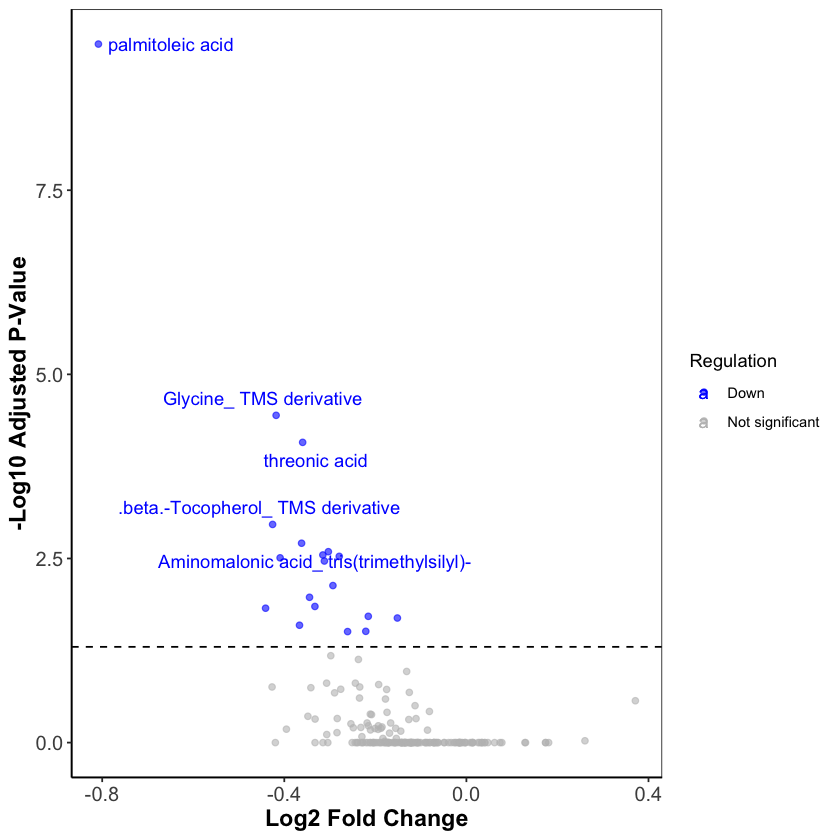

In [60]:
limma_table <- limma_table %>% 
    mutate(Regulation = case_when(
        logFC > 0 & -log10(adj.P.Val) > 1.3 ~ "Up",
        logFC < 0 & -log10(adj.P.Val) > 1.3 ~ "Down",
        TRUE ~ "Not significant"
    ))
    
# Define color palette
color_palette <- c("Up" = "red", "Down" = "blue", "Not significant" = "grey")

# Plot
p <- ggplot(limma_table, aes(x = logFC, y = -log10(adj.P.Val), color = Regulation)) +
  geom_point(alpha = 0.6) +
  scale_color_manual(values = color_palette) +
  geom_hline(yintercept = 1.3, linetype = "dashed") +
  labs(x = "Log2 Fold Change", y = "-Log10 Adjusted P-Value", color = "Regulation") +
  theme_bw() +
  theme(
    axis.line = element_line(colour = "black"),
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 14, face = "bold"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )

# Add labels for top 5 most significant points in each category
top_up_genes <- limma_table %>% 
  filter(Regulation == "Up") %>% 
  arrange(adj.P.Val) %>% 
  head(5)

top_down_genes <- limma_table %>% 
  filter(Regulation == "Down") %>% 
  arrange(adj.P.Val) %>% 
  head(5)

p + 
  geom_text_repel(data = top_up_genes,
                  aes(label = rownames(top_up_genes)),
                  box.padding = unit(0.35, "lines"),
                  point.padding = unit(0.5, "lines"),
                  segment.color = 'grey50',
                  segment.size = 0.2) +
  geom_text_repel(data = top_down_genes,
                  aes(label = rownames(top_down_genes)),
                  box.padding = unit(0.35, "lines"),
                  point.padding = unit(0.5, "lines"),
                  segment.color = 'grey50',
                  segment.size = 0.2)

In [ ]:
# Survival Analysis with significant comparisons
library(survival)
library(survminer)

In [53]:
# Load the dataset
data <- read.csv("sample_annotation.csv")

# Convert event and time columns for Overall Mortality
data$Cox_Mortality <- ifelse(data$Cox_Mortality == "N", 0, 
                             ifelse(data$Cox_Mortality == "Y", 1, NA))
data$Time_death <- as.numeric(data$Time_death)

# Convert event and time columns for RRT Events
data$Cox_RRT <- ifelse(data$Cox_RRT == "N", 0, 
                       ifelse(data$Cox_RRT == "Y", 1, NA))
data$Time_Cox_RRT <- as.numeric(data$Time_Cox_RRT)

# Convert event and time columns for Composite Outcome
data$Cox_Composite_DeathRRT <- ifelse(data$Cox_Composite_DeathRRT == "N", 0, 
                                      ifelse(data$Cox_Composite_DeathRRT == "Y", 1, NA))
data$Time_composite_deathRRT <- as.numeric(data$Time_composite_deathRRT)

# Filter the data to keep only rows where Cox_RRT is either 0 or 1 (after conversion)
filtered_data <- data[!is.na(data$Cox_RRT) & data$Cox_RRT %in% c(0, 1), ]

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”
Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


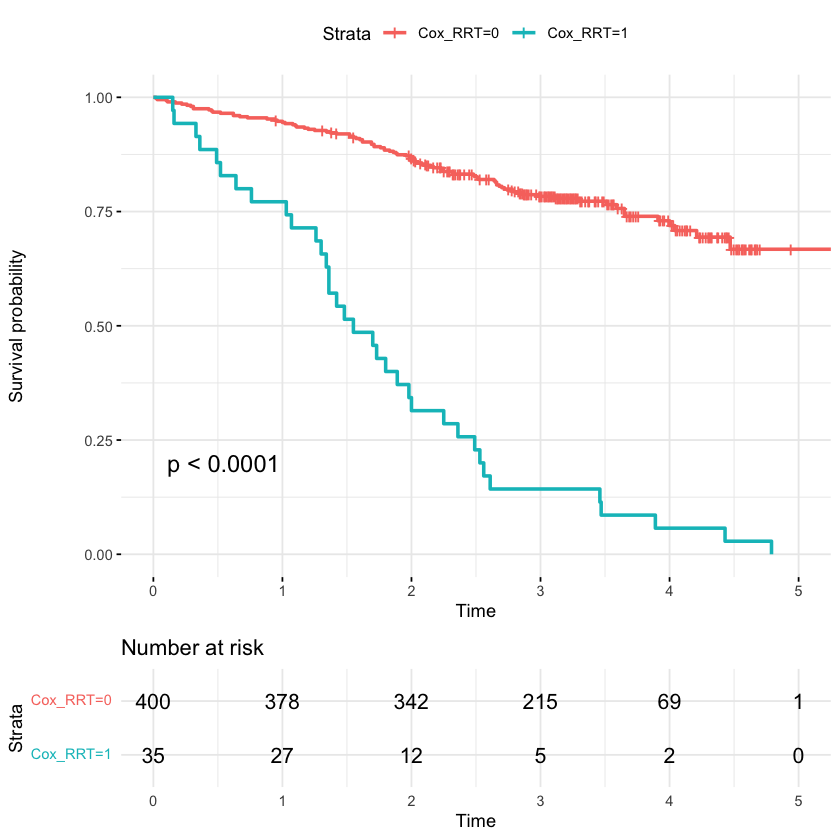

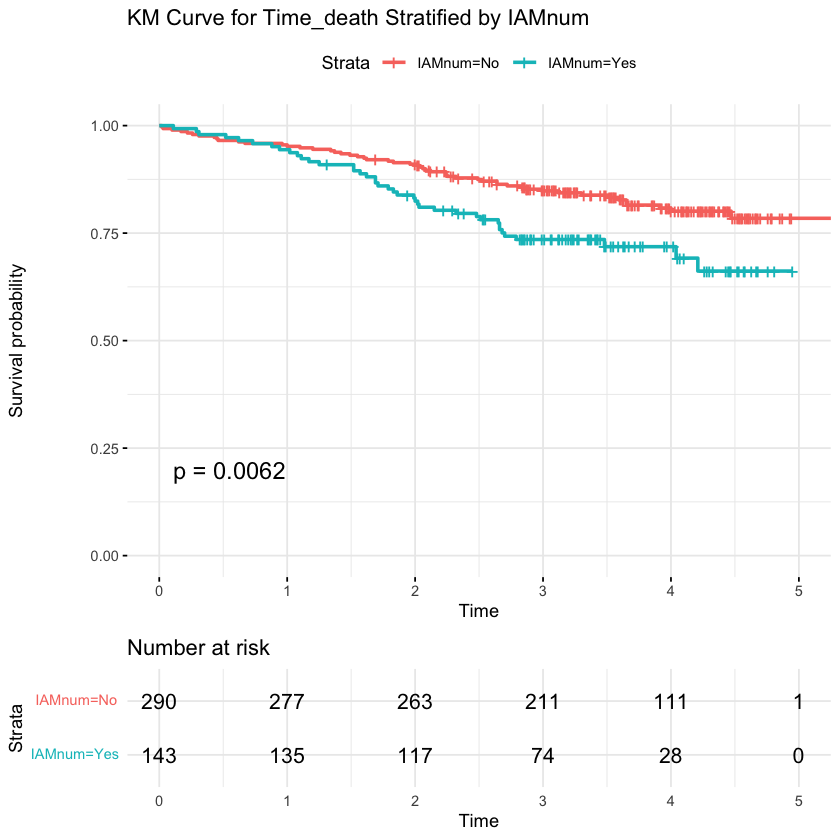

In [59]:
# Create a Surv object and fit the Kaplan-Meier model
surv_obj_composite <- Surv(filtered_data$Time_composite_deathRRT, filtered_data$Cox_Composite_DeathRRT)
km_fit_composite_strata <- survfit(surv_obj_composite ~ Cox_RRT, data=filtered_data)

# Plot
ggsurvplot(km_fit_composite_strata, data=filtered_data, risk.table=TRUE, pval=TRUE, ggtheme=theme_minimal())

# Filter out "-" values
data_iamnum <- data[data$IAMnum != "-", ]
data_iamnum$IAMnum <- as.factor(data_iamnum$IAMnum)

# Create a Surv object for the Time_death column stratified by IAMnum
surv_obj_death_iamnum <- Surv(data_iamnum$Time_death, data_iamnum$Cox_Mortality)
km_fit_death_iamnum <- survfit(surv_obj_death_iamnum ~ IAMnum, data=data_iamnum)
ggsurvplot(km_fit_death_iamnum, data=data_iamnum, risk.table=TRUE, pval=TRUE, ggtheme=theme_minimal(), 
           title="KM Curve for Time_death Stratified by IAMnum")

In [61]:
# Batch Correction

In [62]:
install.packages("sva")
library(sva)

Warning message:
“package ‘sva’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.

Loading required package: genefilter


Attaching package: ‘genefilter’


The following object is masked from ‘package:car’:

    Anova


The following object is masked from ‘package:readr’:

    spec


Loading required package: BiocParallel



In [66]:
data_matrix <- cleaned_data
data_matrix <- t(data_matrix)

# Example data loading
all_data <- samples_meta

# Extract columns for SAMPLE_NAME and Batch
sample_names <- all_data$SAMPLE_NAME
batch_labels_all <- all_data$Batch

batch_labels <- batch_labels_all[match(colnames(data_matrix), sample_names)]

corrected_data <- ComBat(dat=data_matrix, batch=batch_labels, mod=NULL, par.prior=TRUE, prior.plots=FALSE)

Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




In [67]:
# Perform PCA before correction
pca_before <- prcomp(t(data_matrix))

# Plot
df_before <- data.frame(PC1=pca_before$x[,1], PC2=pca_before$x[,2], Batch=batch_labels)
plot_before <- ggplot(df_before, aes(x=PC1, y=PC2, color=Batch)) + geom_point() + ggtitle("PCA Before Correction")

# Perform PCA after correction
pca_after <- prcomp(t(corrected_data))

# Plot
df_after <- data.frame(PC1=pca_after$x[,1], PC2=pca_after$x[,2], Batch=batch_labels)
plot_after <- ggplot(df_after, aes(x=PC1, y=PC2, color=Batch)) + geom_point() + ggtitle("PCA After Correction")

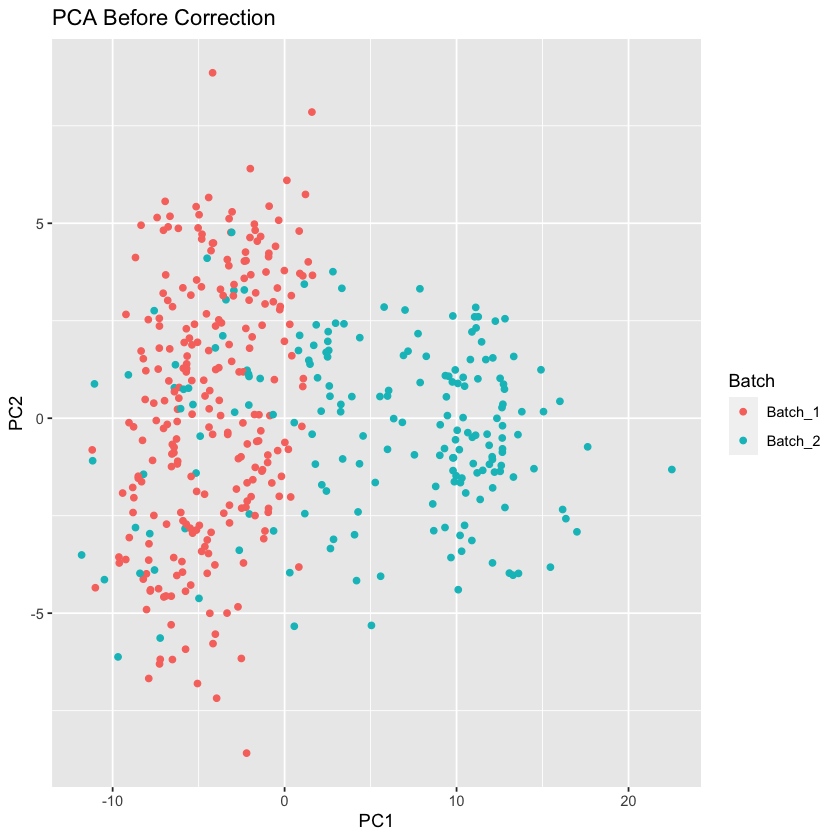

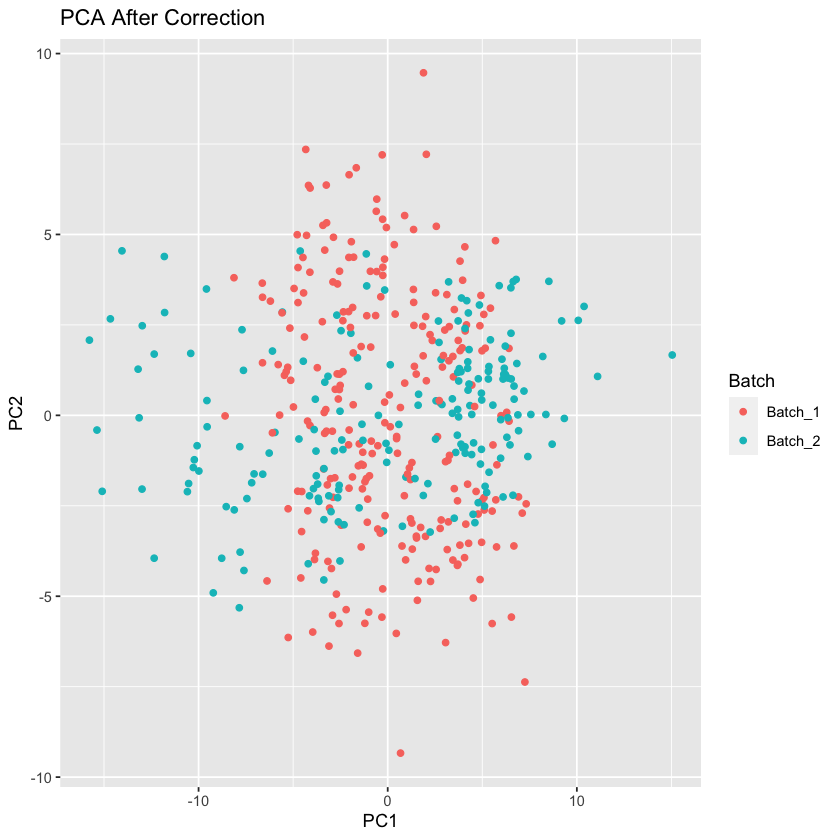

In [71]:
plot(plot_before)
plot(plot_after)

In [77]:
corrected_data <- t(corrected_data)

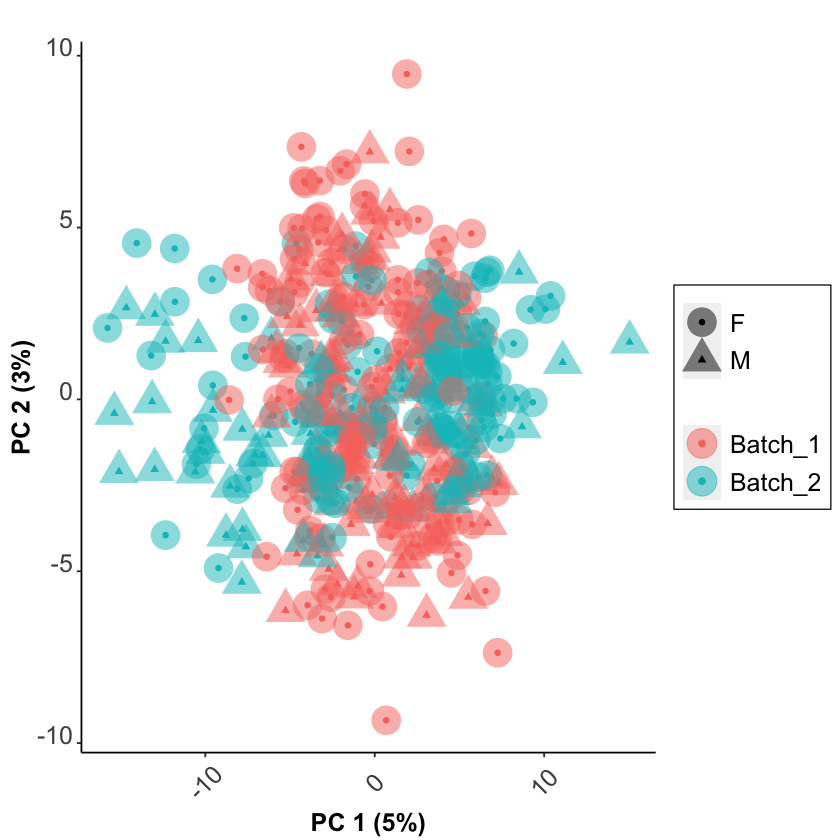

In [78]:
df_pca <- prcomp(corrected_data)
df_out <- as.data.frame(df_pca$x)
PCA_color <- 'Batch'
PCA_shape <- 'Sex'
ggplot(df_out,aes(x=PC1,y=PC2,color=samples_meta[, c(PCA_color)], shape=samples_meta[, c(PCA_shape)]))+
  geom_point()+ggtitle("")+labs(color='')+
  geom_point(size=8,alpha=0.5)+ #Size and alpha just for fun
  theme(  plot.title = element_text(hjust = 0.5,size=15,face = "bold"),
          axis.text.x = element_text( size = 15, angle = 45, hjust = .5, vjust = 0.5, face = "plain"),
          axis.text.y = element_text( size = 15, angle = 0, hjust = 1, vjust = 0, face = "plain"),  
          axis.title.x = element_text( size = 15, angle = 0, hjust = .5, vjust = 0, face = "bold"),
          axis.title.y = element_text( size = 15, angle = 90, hjust = .5, vjust = .5, face = "bold"),
          #legend.title=element_text(size=20),
          legend.title=element_blank(), # remove legend title name
          legend.text = element_text(size=15,face="plain"),
          strip.text = element_text(size = 15,face="plain") ,
          legend.position="right",

          # for transparent background
          panel.background = element_rect(fill = "transparent"), # bg of the panel
          plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
          panel.grid.major = element_blank(), # get rid of major grid
          panel.grid.minor = element_blank(), # get rid of minor grid
          legend.background = element_rect(fill = "transparent"), # get rid of legend bg
          legend.box.background = element_rect(fill = "transparent"), # get rid of legend panel bg
          axis.line = element_line(colour = "black") # adding a black line for x and y axis
  ) +xlab(paste0("PC 1 (", round(df_pca$sdev[1],1),"%)")) +
  ylab(paste0("PC 2 (", round(df_pca$sdev[2],1),"%)"))